# Hierarchal routnig protocol:

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import random

from sklearn.cluster import KMeans


## Building the network and applying K-means clustering

In [2]:
# Final draft
np.random.seed(0)
G = nx.Graph()

##### Defining some network parameters #####
# The dimentions of the area to be monitored
w = 30
h = 30

# The number of nodes
n = 30

##### Creating and placing the nodes #####
# Defining a dict that have the nodes and their position
nodes = {}

# A dict that will have each node and its energy
# nodes_energy = {}

for i in range(n):
    x = np.random.randint(0,w)
    y = np.random.randint(0,h)
    
#     nodes_energy.update({i: 60})
    nodes.update({i: (x,y)})

G.add_nodes_from(nodes.keys())

for node, p in nodes.items():
    G.nodes[node]['pos'] = p
    

##### Finding the clusters using kmean #####
## Defining a list that contains the coordiantes of the different nodes

nodes_coordinates = []
for i in nodes.keys():
    nodes_coordinates.append(nodes[i])

## Applying the kmean algorithm on the nodes
num_of_clusters = 3
kmeans = KMeans(n_clusters=num_of_clusters, random_state=42).fit(nodes_coordinates)
   
## Defining a list that contains the coordiante of each node and its coresponding cluster 
cluster_list = []
for i in range(len(nodes_coordinates)):
    temp = (kmeans.labels_[i], nodes_coordinates[i])
    cluster_list.append(temp)
    
## Defining a list that contain the list of coordinates of each cluster
cluster_list.sort()
clusters = []

for k, g in itertools.groupby(cluster_list, lambda x:x[0]):
    clusters.append([x[1] for x in g])

# Having the node of each cluster in a list
# This list will contain a list of lists, where each list contains a certain cluster
cluster_nodes = []
# This loop will go through each cluster to fill the loop above
for cl in clusters:
    # This list will contain the nodes of a certain cluster
    nodes_same_cluster = []
    # This loop will fill the list above by matching the coordinates of each node with the coordiantes in the cluster
    for coord in cl:
        for node, coordinate in nodes.items():
            if coordinate == coord and node not in nodes_same_cluster:
                nodes_same_cluster.append(node)
    cluster_nodes.append(nodes_same_cluster)
    
    


## Applying the hierarchical routing protocol

In [54]:
# A dict that will have each node and its energy
nodes_energy = {}

for i in range(n):
    nodes_energy.update({i: 50})

# Defining the energy cost of the different transmissions
energy_cost_source = 1
energy_cost_ch = 1.5

# Choose the method by which you want to choose the ch (1 --> based on energy) and (else --> randomly)
ch_method = 1

# Keeping track of some network variables
dead_nodes = []
num_dead_nodes_per_run = []
num_of_rec_msg = []
num_of_sent_msg = []
ntwrk_tot_energy = []
sent_msg_by_src = 0
rec_msg_by_bs = 0

# Appending the initial energy of the network
ntwrk_tot_energy.append(sum(nodes_energy.values()))

# This list will contain the clusters, and it will be modified in the loop
# It was created to avoid changing the original cluster list
cluster_nodes_modifiable = cluster_nodes.copy()

# How many cluster rotations to do
for i in range(10):
    
    # Choosing the cluster heads and adding the edges
    ch_list = []
    for cl in cluster_nodes_modifiable:
        
        # If the ch_method is 1, then the cluster head will be chosen based on energy
        if ch_method == 1:
            
            # Getting the energy of the nodes on the current cluster
            cluster = cl
            cluster_energy = {node:nodes_energy[node] for node in cluster}
            
            # The node with the highest energy will be the cluster head
            ch = max(cluster_energy, key=cluster_energy.get)
        else:
            ch = random.choice(cl)

        # Creating the paths
        for c in cl:
            G.add_edge(c, ch)

        ch_list.append(ch)
        
#     print(ch_list)
#     print(cluster_nodes_modifiable)
#     print(nodes_energy)
#     print(30*'*')
    ##############################################################################
        
    # Adding the base station node

    #bs_x = np.random.randint(0,w)
    #bs_y = np.random.randint(0,h)
    G.add_node('BS',pos=(w/2, h/2))
    nodes.update({'BS': (w/2, h/2)})

    # Connecting the cluster heads to the base station
    for c in ch_list:
        G.add_edge(c, 'BS')

    ##############################################################################
    
    # killing one node
#     nodes_energy[random.choice(ch_list)] = 0
    
    
    ##### Plotting #####
    # Defining the nodes colors
    nodes_color = []
    for node in G:
        if node == 'BS':
            nodes_color.append('green')
        elif node in ch_list:
            nodes_color.append('red')
        else:
            nodes_color.append('blue')

    # Drawing the graph
    # nx.draw(G, pos = nodes, node_color=nodes_color, with_labels=True)
    # plt.draw()
    
#     nx.draw_networkx(G, node_color=nodes_color)
#     plt.title('Network Topology for Round ' + str(1+i))
#     plt.savefig('Network_' + str(1+i) + '.png', bbox_inches='tight')
#     plt.show()

     ##############################################################################
               
    # This list will contain the source nodes
    source_nodes = []
    for i in cluster_nodes_modifiable:
        for j in i:
            if j not in ch_list:
                source_nodes.append(j)
    
    ##############################################################################
    
#     sent_msg_by_src = 0
#     rec_msg_by_bs = 0
    # How many meassages to send per steady state
    for j in range(50):
        
        # Picking a random node to send a message from
        if len(source_nodes) != 0:
            source = random.choice(source_nodes)

        else:
            
            break
        # Checking if this node has enough energy
        if nodes_energy[source] >= energy_cost_source:
            # Incrementing the number of sent messages by 1
            sent_msg_by_src += 1
            # The ch of the chosen node
            source_ch = list(G.neighbors(source))[0]
            # Check if the ch has enough energy
            if nodes_energy[source_ch] >= energy_cost_ch:
                # Sending a message from the source to the bs
                path_to_bs = nx.shortest_path(G,source,'BS')
                # Increment the number of received messages by the bs
                rec_msg_by_bs += 1
                # Decreasing the energy of both the source node and the ch
                nodes_energy[source] = nodes_energy[source] - energy_cost_source
                nodes_energy[source_ch] = nodes_energy[source_ch] - energy_cost_ch
                
                # Appending the current enery in the total energy list for future plotting
                ntwrk_tot_energy.append(sum(nodes_energy.values()))
###############################################
            # Checking if the source node is still alive
            if nodes_energy[source] < energy_cost_source:
                source_nodes.remove(source)
                dead_nodes.append(source)
                # Removing the node from the whole network
                cluster_nodes_modifiable = [[dead_node for dead_node in cluster if dead_node != source] for cluster in cluster_nodes_modifiable]

                #G.remove_node(source)
            # CHeck if the ch has enough energy to operate as a ch
            if nodes_energy[source_ch] < energy_cost_ch:
                # Remove its nodes from the source list
                
                #source_nodes = [alive_node for alive_node in source_nodes if alive_node not in list(G.neighbors(source_ch))]
                
                # Checking if the ch is not fully dead yet
                if nodes_energy[source_ch] < energy_cost_source:
                    dead_nodes.append(source_ch)
                    # Removing the node from the whole network
                    cluster_nodes_modifiable = [[dead_node for dead_node in cluster if dead_node != source_ch] for cluster in cluster_nodes_modifiable]

                    #G.remove_node(source_ch)
################################################                       
    # Removing the edges
    G = nx.create_empty_copy(G)
    

    # Counting the number of dead nodes by this round        
    num_dead_nodes_per_run.append(len(dead_nodes))
    num_of_rec_msg.append(rec_msg_by_bs)
    num_of_sent_msg.append(sent_msg_by_src)

In [20]:
# The number of nodes that died for energy based election of the cluster head over rounds
num_dead_nodes_per_run

[0, 0, 0, 0, 0, 0, 0, 2, 6, 9]

In [7]:
# The nodes that died for energy based election
dead_nodes

[10, 19, 6, 27, 0, 16, 21, 14, 20]

In [18]:
# The number of nodes that died for random election of the cluster head over rounds
ch_random

[0, 0, 0, 2, 4, 6, 7, 9, 11, 16]

In [13]:
# The nodes that died for random election
dead_nodes

[11, 27, 3, 1, 2, 25, 12, 22, 23, 26, 10, 7, 17, 20, 16]

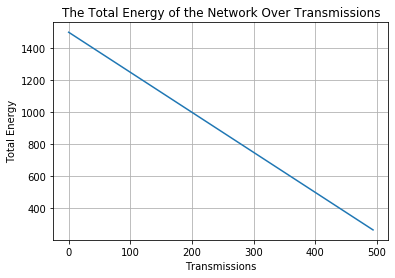

In [56]:
plt.plot(ntwrk_tot_energy)
plt.title('The Total Energy of the Network Over Transmissions')
plt.xlabel('Transmissions')
plt.ylabel('Total Energy')
plt.grid()
plt.savefig('Network energy.png', bbox_inches='tight')
plt.show()

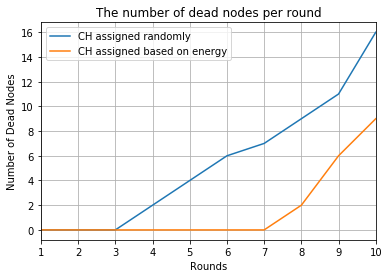

In [28]:
plt.plot(range(1,11), ch_random, label ='CH assigned randomly')
plt.plot(range(1,11),num_dead_nodes_per_run, label ='CH assigned based on energy')
plt.title('The number of dead nodes per round')
plt.xlabel('Rounds')
plt.ylabel('Number of Dead Nodes')
plt.xlim(1,10)
plt.legend()
plt.grid()
plt.savefig('dead nodes per round.png', bbox_inches='tight')
plt.show()

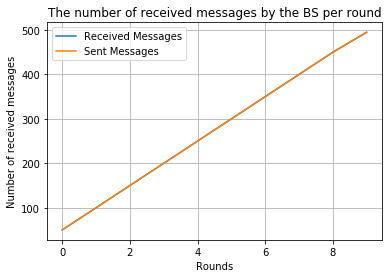

In [11]:
plt.plot(num_of_rec_msg, label ='Received Messages')
plt.plot(num_of_sent_msg, label = 'Sent Messages')
plt.title('The number of received messages by the BS per round')
plt.xlabel('Rounds')
plt.ylabel('Number of received messages')
plt.legend()
plt.grid()
plt.show()